# OPTIMISATION CONVEXE
___

In [1]:
import warnings
import numpy as np
import matplotlib.pyplot as plt

## 1. Descentes de gradient sans contraintes

Familles de fonctions avec nombres de conditionnement quelconques.

In [2]:
ffamilies = [
    lambda k: lambda x: x[0, 0]**2 + k * x[0, 0] * x[0, 1] + x[0,1]**2, # x² + kxy + y²
    lambda k: lambda x: (k+1) * x[0, 0]**2 + x[0,1]**3,                 # kx² + y³
    lambda k: lambda x: k * x[0, 0] + x[0, 1] **2,                      # kx + y²
    lambda k: lambda x: x[0, 0]**2 + k * x[0, 0],                       # x² + kx
    lambda k: lambda x: x[0, 0]**3 + x[0, 0] + k                        # x² + x + k
]

### 1.1 Le Classique

In [3]:
def partial(f, x, i=[0], dx=1e-6):
    """Computes the i-th partial derivative of f at point x.
    
    Args:
        f: objective function.
        x: point at which partial derivative is computed.
        i: list of coordinates along which derivative is computed (differentiates successively once per coordinate).
        dx: slack for finite difference.
        
    Output:
        (float)
    """
    if not i:
        return f(x)
    x = x.reshape(1, -1)
    h = np.zeros(x.shape)
    h[0, i[0]] = dx
    p1 = partial(f, x + h, i[1:], dx)
    p2 = partial(f, x - h, i[1:], dx)
    return (p1 - p2) / (2*dx)

def deriv1(f, x, i, dx=1e-6):
    return partial(f, x, [i], dx)

def deriv2(f, x, i, j, dx=1e-6):
    return partial(f, x, [i, j], dx)

In [4]:
def gradient(f, x, dx=1e-6):
    """Computes gradient of f at point x.
    
    Args:
        f: objective function.
        x: point at which gradient is computed.
        dx: slack for finite difference of partial derivatives.
        
    Output:
        (ndarray) of size domain of f.
    """
    x = x.reshape(1, -1)
    dim = x.shape[1]
    return np.array([deriv1(f, x, i, dx) for i in range(dim)]).reshape(1, -1)

In [5]:
def hessian(f ,x, dx=1e-6):
    """Computes hessian of f at point x.
    
    Args:
        f: objective function.
        x: point at which hessian is computed.
        dx: slack for finite difference of partial derivatives.
        
    Output:
        (ndarray) of square shape and size domain of f.
    """
    x = x.reshape(1, -1)
    dim = x.shape[1]
    line = lambda i: np.array([deriv2(f, x, i, j, dx) for j in range(dim)])
    return np.array([line(i) for i in range(dim)])

# Nombre de conditionnement : rapport entre la plus grande et la
# plus petite des courbures parmi les directions partant de x.
def condition_number(f, x):
    H = hessian(f, x)
    eivals, _ = np.linalg.eig(H)
    return abs(max(eivals) / min(eivals))

In [6]:
i, k, x = 1, 2, np.r_[100, 100]
hessian(ffamilies[i](k), x), condition_number(ffamilies[i](k), x)
for i in range(15):
    print(condition_number(ffamilies[1](i), x))

inf
inf
21.0
inf
11.356388279456786
11.356388279456786
101.99019513592752
101.99019513592752
101.99019513592752
inf
101.99019513592752
inf
inf
101.99019513592752
101.99019513592752


/home/dadou/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars


In [7]:
class ClassicUpdater:
    def __init__(self, rate=0.01, tol=1e-6):
        self.rate = rate if callable(rate) else lambda reset: rate
        self.tol = tol

    def __call__(self, f, x, reset):
        return self.rate(reset) * -gradient(f, x, self.tol)

ln_decay = lambda n: lambda tol: lambda f, x: np.linalg.norm(gradient(f, x, tol), ord=n)
l1_decay = ln_decay(1)
l2_decay = ln_decay(2)

class GD():
    """Gradient Descent Object.
    
    Implements gradient descent aiming to compute optimal objective 
    value of convex functions and local optimal ones of none 
    convex functions.
    """    
    def __init__(self, delta=None, decay=None, tol=1e-6, max_iter=1000):
        """
        Instantiates a GD object.
    
        Attributes:
        delta: function computing descent update vector (direction + step)
        decay: function computing decay
        tol: slack tolerance.
        max_iter: upper bound on number of iterations.
        """
        self.delta = delta if delta is not None else ClassicUpdater(0.01, tol)
        self.decay = decay if decay is not None else l2_decay(tol)
        self.tol = tol
        self.max_iter = max_iter
        self.grad = gradient
    
    def __call__(self, x, f):
        """Calling gradient descent object with specific starting point and optimal function.
        
        Args:
            x: initial starting point for descent.
            f: objective function of optimisation problem.
        
        Output:
            (float) sub-optimal value up to tolerance if execution is proper.
            (ndarray) list of gradient descent iterates.
        """
        # Helper functions
        compute_delta = lambda x, reset=False: self.delta(f, x, reset)
        compute_decay = lambda x: self.decay(f, x)
        
        # Start
        x = x.reshape(1, -1)
        n_iter = 0
        iters, iters_dir = x, compute_delta(x, reset=True)
        decay = compute_decay(x)
        while decay > self.tol and n_iter < self.max_iter:
            ## Decide on direction
            delta = compute_delta(x)
            ## Update iterate
            x = x + delta
            ## Store on-going data
            iters = np.vstack([iters, x])
            iters_dir = np.vstack([iters_dir, delta])
            ## Update decay
            decay = compute_decay(x)
            ## Update iteration number
            n_iter += 1

        # Display results
        msg = " Iteration nu. = {}\n approx. = {}\n ob value = {}\n and decay = {}."
        #print(msg.format(n_iter, x.flatten(), f(x), decay))
        if decay > self.tol:
            warnings.warn("Decay didn't get under tolerance rate.", RuntimeWarning)
        return (x, iters, iters_dir, n_iter) 

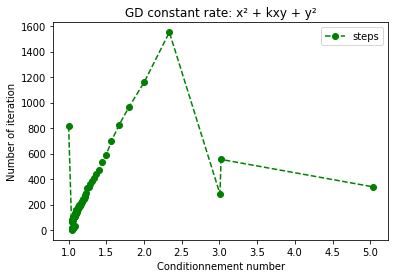

In [8]:
def plot_gradient_descent(f, x, k_max, str_name, rate=0.01, max_cond=100, max_iter_per_gd=2000):
    """Plot the number iterations of a constant gradient descent of f at point x with several k,
       contrasted with the conditionnement number
    
    Args:
        f: objective function.
        x: point at which gradient is computed.
        k_max: number of k (0 to k_max)
        str_name: string name of the function
    """
    DG_classic = GD(ClassicUpdater(rate=rate), max_iter=max_iter_per_gd)

    list_iter = [DG_classic(x, f(k))[3] for k in range(k_max)]
    list_cond = [condition_number(f(k), x) for k in range(k_max)]

    array_cond = np.array(list_cond)
    array_iter = np.array(list_iter)

    array_tuple = list(filter(lambda tup: tup[0] < max_cond, zip(array_cond, array_iter)))
    array_tuple.sort(key=lambda tup: tup[0])

    array_cond_iter = list(zip(*array_tuple))

    plt.plot(array_cond_iter[0], array_cond_iter[1], "--go", label="steps")
    plt.legend(loc='upper right')
    plt.xlabel("Conditionnement number")
    plt.ylabel("Number of iteration")
    plt.title("GD constant rate: " + str_name)

    plt.show()
    
plot_gradient_descent(ffamilies[0], np.r_[5, 5], 100, "x² + kxy + y²")

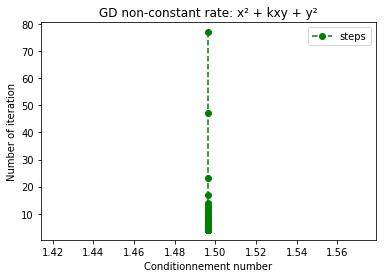

In [9]:
def plot_GD_unconstant(f, x, k, str_name, max_rate, max_cond=100, max_iter_per_gd=2000):
    list_iter = []
    list_cond = []
    for rate in np.arange(0.1, max_rate, 0.1):
        DG_classic = GD(ClassicUpdater(rate), max_iter=max_iter_per_gd)
        list_iter.append(DG_classic(x, f(k))[3])
        list_cond.append(condition_number(f(k), x))

    array_cond = np.array(list_cond)
    array_iter = np.array(list_iter)

    array_tuple = list(filter(lambda tup: tup[0] < max_cond, zip(array_cond, array_iter)))
    array_tuple.sort(key=lambda tup: tup[0])

    array_cond_iter = list(zip(*array_tuple))

    plt.plot(array_cond_iter[0], array_cond_iter[1], "--go", label="steps")
    plt.legend(loc='upper right')
    plt.xlabel("Conditionnement number")
    plt.ylabel("Number of iteration")
    plt.title("GD non-constant rate: " + str_name)

    plt.show()

plot_GD_unconstant(ffamilies[0], np.r_[5, 5], 10, "x² + kxy + y²", 50)

In [10]:
DG_classic = GD()
DG_classic(np.r_[1, 1], ffamilies[0](0))
print()

### 1.2 Accélération de convergence

#### Learning Rate Scheduling

Le Learning Rate Scheduling (LRS) visent à ajuster le taux d'apprentissage pendant la formation en réduisant le taux d'apprentissage selon un schedule prédéfini. Les Learning Rate Scheduling comprennent la décroissance temporelle, la décroissance par paliers et la décroissance exponentielle.

In [11]:
class ExponentialLRScheduler:
    def __init__(self, initial_rate=0.1, r=0.1):
        self.initial_rate = initial_rate
        self.r = r

    def __call__(self, reset):
        if reset:
            self.n_iter = 0
        return self.initial_rate * 10**(- self.n_iter / self.r)

In [12]:
DG_classic = GD(ClassicUpdater(ExponentialLRScheduler()))
DG_classic(np.r_[15, 20], ffamilies[0](0))
print()

#### Nesterov Accelerated Gradient

La Nesterov Accelerated Gradient (NAG) consiste en une étape de descente en gradient, suivie par quelque chose de très similaire au momentum, mais pas exactement la même que celle trouvée dans le momentum classique.

In [13]:
class NesterovUpdater:
    def __init__(self, rate=0.01, momentum=0.9, tol=1e-6):
        self.rate = rate
        self.momentum = momentum
        self.tol = tol
    
    def __call__(self, f, x, reset):
        x = x.reshape(1, -1)
        if reset is True:
            self.m_vect = np.zeros(x.shape[1])
        mv = self.momentum * self.m_vect
        self.m_vect = mv - self.rate * gradient(f, x + mv, self.tol)
        return self.m_vect

In [14]:
DG_nesterov = GD(NesterovUpdater())
DG_nesterov(np.r_[15, 20], ffamilies[0](0))
print()

#### Adam Optimization

Adam Optimization est différent de la descente de gradient classique.
La descente de gradient maintient un taux d'apprentissage unique pour toutes les mises à jour de poids et le taux d'apprentissage ne change pas pendant l'entraînement.
Un taux d'apprentissage est maintenu pour chaque poids de réseau (paramètre) et adapté séparément à mesure que l'apprentissage se déroule.

In [15]:
class AdamUpdater:
    def __init__(self, rate=0.01, beta1=0.9, beta2=0.9, tol=1e-6, epsilon=1e-7):
        self.rate = rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.tol = tol
        self.epsilon = epsilon

    def __call__(self, f, x, reset):
        x = x.reshape(1, -1)
        if reset is True:
            self.n_iter = 1
            self.m_vect = np.zeros(x.shape[1])
            self.s_vect = np.zeros(x.shape[1])
        gf = gradient(f, x, self.tol)
        m = self.beta1 * self.m_vect - (1 - self.beta1) * gf
        s = self.beta2 * self.s_vect + (1 - self.beta2) * gf * gf
        self.m_vect = m / (1 - self.beta1**self.n_iter)
        self.s_vect = s / (1 - self.beta2**self.n_iter)
        return self.rate * self.m_vect / np.sqrt(self.s_vect + self.epsilon)

In [16]:
DG_adam = GD(AdamUpdater())
DG_adam(np.r_[15, 20], ffamilies[0](0))
print()

## 2. Thématiques plus avancées

### 2.1 Méthode de Newton

In [17]:
def newton(f, x, rate=0.1, tol=1e-6):
    """Computes a local minimum of f at point x using Newton's method.
    
    Args:
        f: objective function.
        x: starting point
        tol: tolerance used for hessian computation and stop condition
        
    Output:
        (ndarray) of the same shape as x.
    """
    lamda = 2.0 * tol + 1
    n_iter = 0
    while lamda/2 > tol:
        delta = np.linalg.inv(hessian(f, x, tol)) @ gradient(f, x, tol).T
        lamda = np.dot(gradient(f, x, tol), delta)
        x = x - rate * delta
        n_iter += 1
    return x, n_iter

In [18]:
newton(lambda x: x[0,0]**2 + x[0,1]**2, np.r_[5, 5])

LinAlgError: Singular matrix

### 2.2 SVM et SMO